## Import Libraries and Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

In [2]:
# Load in the persons PUMS dataset for WA state
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

## Choose PUMS and Preprocess

In [3]:
# Filter to desired variables (numeric then categorical)
pums_data = h_df[['HINCP','NP','VEH']]

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

Dataset n=164836 pre-cleaning
Dataset n=140586 post-cleaning


In [4]:
CAT_IDX = 1
VAR_DIM = pums_data.shape[1]
VAR_NAMES = pums_data.columns

# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
for x in range(CAT_IDX, VAR_DIM):
    dummies = pums_data.iloc[:,x]
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
CAT_LENGTHS = [x.shape[1] for x in dummies_list]

In [5]:
# Final data frame after encoding OHE
model_data_df = pums_data.iloc[:,:CAT_IDX]
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
MANIFEST_DIM = model_data_df.shape[1]

# Preview data that will be fed into model
model_data_df

,HINCP,NP__1,NP__2,NP__3,NP__4,NP__5,NP__6,NP__7,NP__8,NP__9,...,NP__16,NP__19,NP__20,VEH__0.0,VEH__1.0,VEH__2.0,VEH__3.0,VEH__4.0,VEH__5.0,VEH__6.0
0,102200.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,69360.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,210500.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,50310.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,31200.0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161771,141370.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
161772,60000.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
161774,55000.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
161775,102000.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# Standardize the input data from -1 to 1 for numerical variables
scaler = skpre.StandardScaler()
model_data = model_data_df.values
model_data[:,:CAT_IDX] = scaler.fit_transform(model_data[:,:CAT_IDX])

# Remove rows with numerical outliers (3 < standard deviations)
outlier_row_indices = np.where(np.any(model_data[:,:CAT_IDX] > 3, axis=1))
model_data = np.delete(model_data, (outlier_row_indices), axis=0)

# Separate into train/test data
train_idx = round(len(model_data)*.9)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

## Set Parameters and Define Model

In [7]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 100
LEARN_RATE = 0.001
RHO = 0.9
LATENT_DIM = 2
HIDDEN_DIM = 100
KL_WEIGHT = 0.5

In [8]:
# A layer that takes mean/variance as inputs and returns a random sample z
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_var) * epsilon

In [9]:
# Encoder
encoder_inputs = keras.Input(shape=(MANIFEST_DIM,))
encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_inputs)
encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(encoder_x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(encoder_x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 26)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          2700        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          10100       dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            202         dense_1[0][0]                    
____________________________________________________________________________________________

In [10]:
# Decoder
decoder_inputs = keras.Input(shape=(LATENT_DIM,))
decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_inputs)
decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_x)
decoder_num_outputs = layers.Dense(CAT_IDX, activation="linear")(decoder_x)
decoder_cat_outputs = []
for var_length in CAT_LENGTHS:
    layer = layers.Dense(var_length, activation="softmax")(decoder_x)
    decoder_cat_outputs.append(layer)
decoder = keras.Model(decoder_inputs, [decoder_num_outputs, decoder_cat_outputs], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          300         input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 100)          10100       dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1)            101         dense_3[0][0]                    
____________________________________________________________________________________________

In [11]:
# Define custom loss function for combined numerical and categorical data
def get_reconstruction_loss(data, reconstruction, CAT_IDX, CAT_LENGTHS):
    # Handle case with no categorical variables
    if len(CAT_LENGTHS) > 0:
        reconstruction_num = reconstruction[0]
    else:
        reconstruction_num = reconstruction

    # Mean squared error for numerical variables
    data_num = data[:,:CAT_IDX]
    loss_num = keras.losses.mean_squared_error(data_num, reconstruction_num)
    loss_num = tf.reduce_mean(loss_num)
    
    # Categorical cross entropy for categorical variables
    loss_list = []
    current = CAT_IDX
    for i, x in enumerate(CAT_LENGTHS):
        data_cat = data[:,current:(current + x)]
        reconstruction_cat = reconstruction[1][i]
        loss = keras.losses.categorical_crossentropy(data_cat, reconstruction_cat, from_logits=False)
        loss = tf.reduce_mean(loss)
        loss_list.append(loss)
        current += x
    loss_cat = tf.reduce_sum(loss_list)

    # Return both losses; they are combined in the model
    return (loss_num, loss_cat)

def get_kl_loss(z_mean, z_log_var):
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss = -kl_loss
    return kl_loss

In [12]:
# Loss metric recorder
loss_tracker = keras.metrics.Mean(name="loss")

# Variational Autoencoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, CAT_IDX, CAT_LENGTHS, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.CAT_IDX = CAT_IDX
        self.CAT_LENGTHS = CAT_LENGTHS

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # Get latent vars from the encoder; feed to decoder and get sampled manifest variables
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)

            # Get loss between input values and reconstruction
            reconstruction_loss_num, reconstruction_loss_cat = get_reconstruction_loss(
                data,
                reconstruction,
                self.CAT_IDX,
                self.CAT_LENGTHS
            )
            reconstruction_loss = tf.add(reconstruction_loss_num, reconstruction_loss_cat)

            # Get Kullback Leidler loss between normal distribution and actual for latent variables
            kl_loss = get_kl_loss(z_mean, z_log_var)
            kl_loss = kl_loss * KL_WEIGHT

            # Combine into single loss term
            total_loss = reconstruction_loss + kl_loss

        # Get new gradients given the loss and take another step (update weights)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Record the loss metrics
        loss_tracker.update_state(total_loss)

        return {
            "total_loss": loss_tracker.result(),
            "reconstruction_loss": reconstruction_loss,
            "reconstruction_loss_num": reconstruction_loss_num,
            "reconstruction_loss_cat": reconstruction_loss_cat,
            "kl_loss": kl_loss,
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    @property
    def metrics(self):
        return [loss_tracker]

## Training

In [13]:
# Train
vae = VAE(encoder, decoder, CAT_IDX, CAT_LENGTHS)
vae.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARN_RATE, rho=RHO))
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/100
1935/1935 [==============================] - 5s 2ms/step - total_loss: 2.3236 - reconstruction_loss: 1.1224 - reconstruction_loss_num: 0.3537 - reconstruction_loss_cat: 0.7687 - kl_loss: 0.7559
Epoch 2/100
1935/1935 [==============================] - 5s 3ms/step - total_loss: 1.4283 - reconstruction_loss: 0.4841 - reconstruction_loss_num: 0.2712 - reconstruction_loss_cat: 0.2129 - kl_loss: 0.9084
Epoch 3/100
1935/1935 [==============================] - 4s 2ms/step - total_loss: 1.3255 - reconstruction_loss: 0.3822 - reconstruction_loss_num: 0.2157 - reconstruction_loss_cat: 0.1666 - kl_loss: 0.9327
Epoch 4/100
1935/1935 [==============================] - 5s 2ms/step - total_loss: 1.2900 - reconstruction_loss: 0.3367 - reconstruction_loss_num: 0.1935 - reconstruction_loss_cat: 0.1432 - kl_loss: 0.9414
Epoch 5/100
1935/1935 [==============================] - 4s 2ms/step - total_loss: 1.2567 - reconstruction_loss: 0.3062 - reconstruction_loss_num: 0.1775 - reconstruction_loss_

1935/1935 [==============================] - 4s 2ms/step - total_loss: 1.1553 - reconstruction_loss: 0.2040 - reconstruction_loss_num: 0.1139 - reconstruction_loss_cat: 0.0901 - kl_loss: 0.9546
Epoch 80/100
1935/1935 [==============================] - 5s 2ms/step - total_loss: 1.1548 - reconstruction_loss: 0.2029 - reconstruction_loss_num: 0.1139 - reconstruction_loss_cat: 0.0889 - kl_loss: 0.9546
Epoch 81/100
1935/1935 [==============================] - 5s 2ms/step - total_loss: 1.1597 - reconstruction_loss: 0.2024 - reconstruction_loss_num: 0.1145 - reconstruction_loss_cat: 0.0878 - kl_loss: 0.9549
Epoch 82/100
1935/1935 [==============================] - 4s 2ms/step - total_loss: 1.1575 - reconstruction_loss: 0.2024 - reconstruction_loss_num: 0.1138 - reconstruction_loss_cat: 0.0887 - kl_loss: 0.9540
Epoch 83/100
1935/1935 [==============================] - 4s 2ms/step - total_loss: 1.1565 - reconstruction_loss: 0.2040 - reconstruction_loss_num: 0.1145 - reconstruction_loss_cat: 0.0

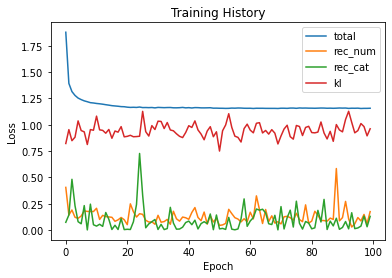

In [14]:
# Plot model loss/training progress
plt.plot(history.history['total_loss'])
plt.plot(history.history['reconstruction_loss_num'])
plt.plot(history.history['reconstruction_loss_cat'])
plt.plot(history.history['kl_loss'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","rec_num","rec_cat","kl"], loc="upper right")
plt.show()

## Testing

Latent Variable: 0
Mean: 0.01914486661553383
Variance: 1.1081804037094116



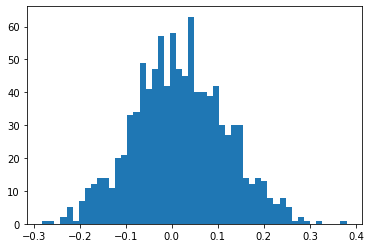

Latent Variable: 1
Mean: 0.035873495042324066
Variance: 1.103913426399231



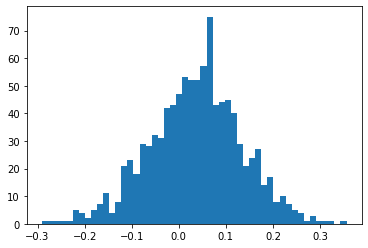

In [15]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Record the posterior trained distributions for z
latent_means = []
latent_vars = []

# Determine the average values for the mean/logvariance of the latent variables
for i in range(0, LATENT_DIM):
    epsilon = np.random.normal(loc=0, scale=1, size=1000)
    avg_mean = np.mean(z_mean[:,i])
    latent_means.append(avg_mean)
    avg_var = np.exp(np.mean(z_logvar[:,i]))
    latent_vars.append(avg_var)
    print(f"Latent Variable: {i}")
    print(f"Mean: {avg_mean}")
    print(f"Variance: {np.exp(avg_var)}\n")
    samples = avg_mean + (avg_var * epsilon)
    plt.hist(samples, bins=50)
    plt.show()

In [16]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_num, loss_cat = get_reconstruction_loss(test_data, results, CAT_IDX, CAT_LENGTHS)
print(f"Numerical Variable Loss: {loss_num}")
print(f"Categorical Variable Loss: {loss_cat}")

Numerical Variable Loss: 0.13294243812561035
Categorical Variable Loss: 0.13338696956634521


In [17]:
# Handle case where no categorical variables
if len(CAT_LENGTHS) > 0:
    # Transform numeric results back to real variable values
    results_num = scaler.inverse_transform(results[0])
    results_df = pd.DataFrame(results_num)

    # Transform categorical results back to real variable values
    for x in results[1]:
        result = np.argmax(x, axis=1) + 1
        results_df[f"{x}"] = result
else:
    results_num = scaler.inverse_transform(results)
    results_df = pd.DataFrame(results_num)

# Add back original variables names to the results
results_df.columns = VAR_NAMES

In [19]:
# Transform numeric test data back to real variable values
test_data_num = scaler.inverse_transform(test_data[:,:CAT_IDX])
test_data_df = pd.DataFrame(test_data_num)

# Handle case where no categorical variables
if len(CAT_LENGTHS) > 0:
    # Transform categorical test data back to real variable values
    current = CAT_IDX
    for x in CAT_LENGTHS:
        test_data_cat = test_data[:,current:(current + x)]
        test_data_cat = np.argmax(test_data_cat, axis=1) + 1
        test_data_df[f"{x}"] = test_data_cat
        current += x

# Add back original variables names to the test data
test_data_df.columns = VAR_NAMES

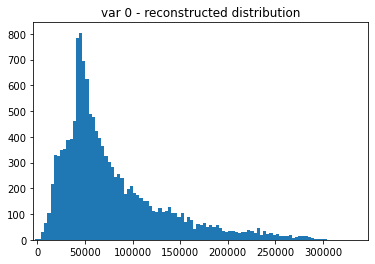

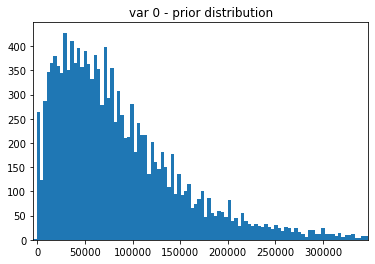

In [20]:
# Show distributions of the resulting numerical variables
for col_idx in range(0, CAT_IDX):
    results_data_plt = results_df.iloc[:,col_idx]
    test_data_plt = test_data_df.iloc[:,col_idx]

    plt.hist(results_data_plt, bins=100)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()

    plt.hist(test_data_plt, bins=100)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()

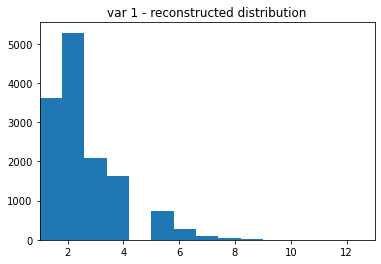

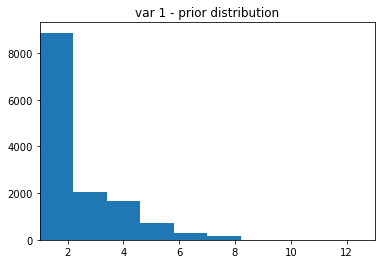

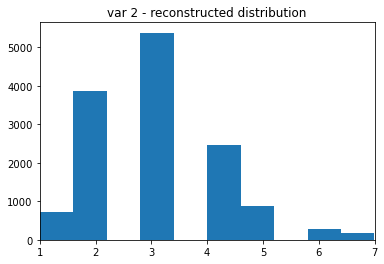

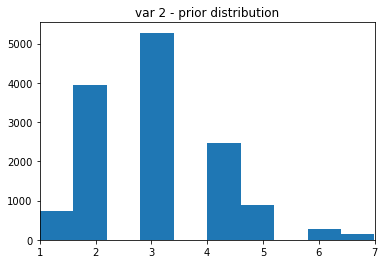

In [21]:
# Show distributions of the resulting categorical variables
for col_idx in range(CAT_IDX, VAR_DIM):
    results_data_plt = results_df.iloc[:,col_idx]
    test_data_plt = test_data_df.iloc[:,col_idx]
    
    plt.hist(results_data_plt)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()
    
    plt.hist(test_data_plt)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()

## Generating Synthetic Population

In [22]:
start_time = time.time()

In [23]:
# How many synthetic households to generate
POP_SIZE = 750000

# Generate random normal sample to represent each latent variable, for each row (different hh per row)
inputs = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

# Generate persons; each person has unique latent input, plus shared hh inputs with their household
results = vae.decoder.predict(inputs)

In [24]:
print(f"--- {time.time() - start_time} seconds ---")

--- 17.739540576934814 seconds ---


In [25]:
# Transform numeric results back to real variable values
results_num = scaler.inverse_transform(results[0])
results_df = pd.DataFrame(results_num)

# Transform categorical results back to real variable values
for x in results[1]:
    result = np.argmax(x, axis=1) + 1
    results_df[f"{x}"] = result

# Add back original variables names to the results
results_df.columns = VAR_NAMES

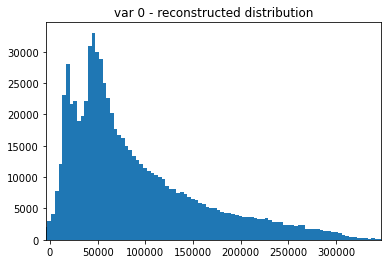

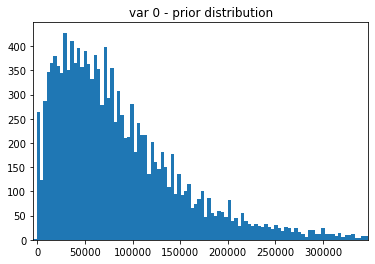

In [26]:
# Show distributions of the resulting numerical variables
for col_idx in range(0, CAT_IDX):
    results_data_plt = results_df.iloc[:,col_idx]
    test_data_plt = test_data_df.iloc[:,col_idx]

    plt.hist(results_data_plt, bins=100)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()

    plt.hist(test_data_plt, bins=100)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()

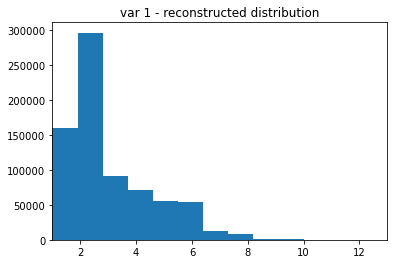

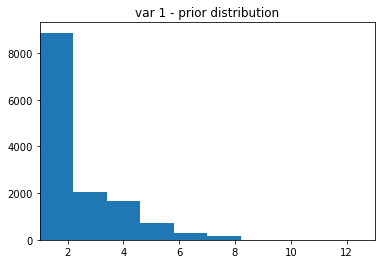

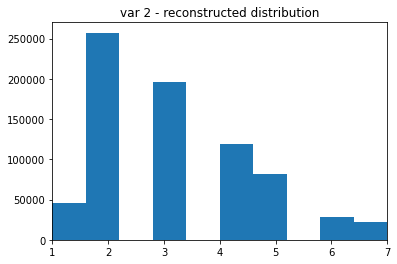

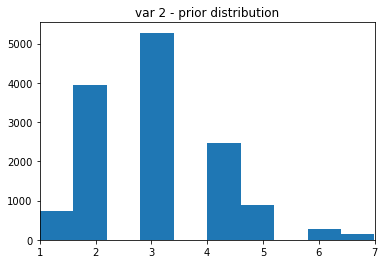

In [27]:
# Show distributions of the resulting categorical variables
for col_idx in range(CAT_IDX, VAR_DIM):
    results_data_plt = results_df.iloc[:,col_idx]
    test_data_plt = test_data_df.iloc[:,col_idx]
    
    plt.hist(results_data_plt)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()
    
    plt.hist(test_data_plt)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()

In [28]:
# Save the synthesized households
results_df.to_csv('data/synthetic_populations/wa_households.csv', index=False)
results_df

,HINCP,NP,VEH
0,118592.328125,5,2
1,21326.982422,1,1
2,99697.726562,1,2
3,66527.679688,5,2
4,60233.859375,2,6
...,...,...,...
749995,168711.562500,2,2
749996,30963.396484,1,2
749997,228661.843750,1,3
749998,34632.007812,1,3
